<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 30px;">   
   <strong> Deep Learning in Finance MAP548 -  Tutorial 3 </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Deep pricing and calibration  </strong></p>
</header>


In [1]:
import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
plt.rcParams["figure.figsize"] = (4.8, 3.2)
import urllib
import os
from tqdm.keras import TqdmCallback
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

from math import exp, sqrt, log, pi, sin, cos, atan, tan
import math
import cmath
from cmath import exp as cexp
from cmath import sqrt as csqrt
from cmath import log as clog
from cmath import phase as phase
from cmath import polar as polar

from functools import partial
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.model_selection import train_test_split

import scipy
from scipy import optimize, stats
from scipy.optimize import minimize

from random import gauss, uniform
from tqdm.notebook import tqdm

from scipy.special import gamma as gamma_func
import mpmath as mp #with special hypergeometric functions
from scipy.special import hyp2f1 as hyp_2f1

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings 
warnings.filterwarnings('ignore') #to suppress warning messages
import itertools



<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;"> One Factor Bergomi Model </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 



The (one factor) Bergomi Model (Dupire, 1992; L Bergomi, 2005) under the risk-neutral filtered probability space $(\Omega, \mathcal F,(\mathcal F_t)_{t\geq 0}, \mathbb Q )$  has the following dynamics:


\begin{equation}
  \begin{aligned}
    S_t &= S_0\exp\left(\int_0^t\sqrt{V_s}dB_s - \frac 1 2 \int_0^t V_s ds \right), \quad S_0>0\\
    V_t &= \xi \exp{\left(\eta X_t-\frac{1}{2} \eta^2 \frac{(1-e^{-2\kappa t})}{2\kappa} \right)},\\
      X_t &=  \int_0^t e^{-\kappa(t-s)} dW_s,
  \end{aligned}
  \end{equation}

where $ B=\rho W + \sqrt{1-\rho^2} W^{\perp}$ with $(W,W^{\perp})$ a two-dimensional Brownian motion, $\rho \in [-1,1]$.

$X_t$ is a Ornstein–Uhlenbeck (Gaussian) process. In particular, $X_t \sim \mathcal{N}(0, \frac{(1-e^{-2\kappa t})}{2\kappa})$.

There are in total four model parameters: $(\xi, \kappa, \eta, \rho)$.

We are interested in computing the price of European style contingent claims, with payoff $g(S_T)$ for some function $g$:
$$
C_t = \mathbb{E} \left[g(S_T) \vert \mathcal F_t) \right].
$$

For European vanilla call options, with $g(x) = (x-K)^{+}$ with strike $K$; no closed form formula to compute $g(S_T)$



<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Simulation of X  </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 



### (1) Scheme one

1.  How to simulate exactly a Gaussian vector $X^n$ with known mean vector $\mu \in \mathbb R^{n}$ and covariance matrix $\Sigma \in \mathbb R^{n\times n}$?






Cholesky method:

> **A** Apply the Cholesky decomposition on $\Sigma:$
$$ \Sigma = L L^{\top}$$
where $L$ is lower triangular with nonnegative diagonal entries.
Simulate a $\mathbb R^{n}$ gaussian vector $Z\sim \mathcal N(0, I_{n})$
Compute
$$ \mu + LZ.$$


2. Simulate the Ornstein-Uhlenbeck process knowing that the covariance function $\Sigma(s,u) := \mathbb{E}[X_sX_u]$ is:

$$
\Sigma(s,u) = \frac{e^{-\kappa \vert u-s \vert }-e^{-\kappa (s+u)}}{2\kappa},
$$



In [3]:
def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

In [26]:
xi, kappa,eta,rho, = 0.02,3,5,-0.7
T = 2
n_steps = 1000
N_sims = 50

In [27]:
dt = T/n_steps
tt = np.linspace(0., T, n_steps + 1)

#Cholesky
ti_1 = np.tile(tt[1:],n_steps).reshape(n_steps,n_steps).T
tj_1 = ti_1.T
cov_matrix = cov_matrix = (np.exp(np.abs(ti_1-tj_1)*(-kappa))-np.exp((ti_1+tj_1)*(-kappa)))/(2*kappa)
L = np.linalg.cholesky(cov_matrix)

In [28]:
np.random.seed(42)
w1=gen_bm_path(n_steps,N_sims)

In [29]:
Xt = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],
            L@w1))

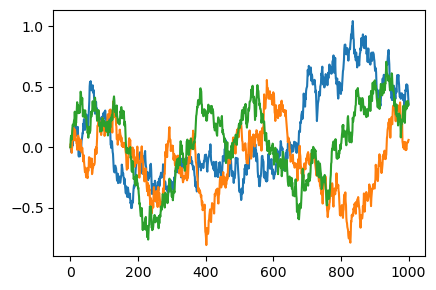

In [31]:
plt.plot(Xt[:,1],label='scheme 1')
plt.plot(Xt[:,2],label='scheme 1')
plt.plot(Xt[:,3],label='scheme 1')
plt.show()

### Scheme two: recursive

3. Can you think of  a recursive scheme?  What are the advantages compared to the previous one?
4. Implement the scheme


Define the process 

$$
\widetilde X_t = e^{\kappa t}X_t = \int_0^t e^{\kappa s} dW_s,
$$

so that

$$
\widetilde X_{t_{j+1}} = \widetilde X_{t_j} + \int_{t_{j}}^{t_{j+1}}e^{\kappa s} dW_s =  \
    \widetilde X_{t_j}+\sqrt{\frac{e^{2 \kappa t_{j+1}}-e^{2 \kappa t_{j}}}{2\kappa}}Y_j,
$$

with $t_0 = 0, \quad t_N = T, \quad Y_i  \sim \mathcal{N}(0, 1)$ iid. Thus we first simulate $\widetilde X_{t_{j+1}}$ and then convert back to $X_t$ by:

$$
 X_t = e^{-\kappa t} \widetilde X_t.
$$

In [32]:
exp1 = np.exp(kappa*tt[1:])
exp2 = np.exp(2*kappa*tt)

diff_exp2 = np.diff(exp2)
std_vec = np.sqrt(diff_exp2/(2*kappa))[:,np.newaxis] #to be broadcasted columnwise 
exp1 = exp1[:,np.newaxis]
Xt2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1)*np.cumsum(std_vec*w1, axis = 0)))

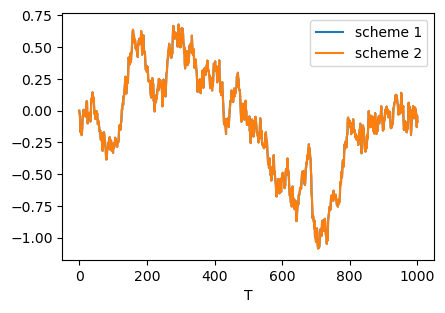

In [33]:
i_ind = 10
plt.plot(Xt[:,i_ind],label='scheme 1')
plt.plot(Xt2[:,i_ind],label='scheme 2')
plt.xlabel('T')
plt.legend()
plt.show()



<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;"> Simulation of $V$ and $S$ </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 



4. Simulation of $V$ is obvious once $X$ is available.



Simulate $\log S$: Euler Maruyama scheme:

$$
\log S_{t_{i+1}} = \log S_{t_i}-\frac{1}{2}V_{t_i}(t_{i+1}-t_{i}) + \sqrt{(t_{i+1}-t_{i})V_{t_i}} \left(\rho \mathcal{N} +  \sqrt{(1-\rho^2)}\mathcal{N}^{\perp}\right),
$$

with $\mathcal{N}$ and $\mathcal{N}^{\perp}$ standard independent Gaussian

In [34]:
S0 = 100
np.random.seed(111)
w2=gen_bm_path(n_steps,N_sims)

In [35]:
drift = eta**2*(1-np.exp(-2*kappa*tt))/(2*kappa)
Vt = xi*np.exp(eta*Xt-0.5*drift[:,np.newaxis])

In [41]:
log_S = np.ones(N_sims).reshape(1,-1)*log(S0)
epochs_iter_j = tqdm(range(n_steps), desc="iteration", miniters=2000)
for j in epochs_iter_j:
    log_S_next = log_S[j]-0.5*Vt[j]*dt+np.sqrt(Vt[j]*dt)*\
        (rho*w1[j]+sqrt(1-rho**2)*w2[j])
    log_S=np.append(log_S,log_S_next.reshape(1,-1),axis=0)

iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

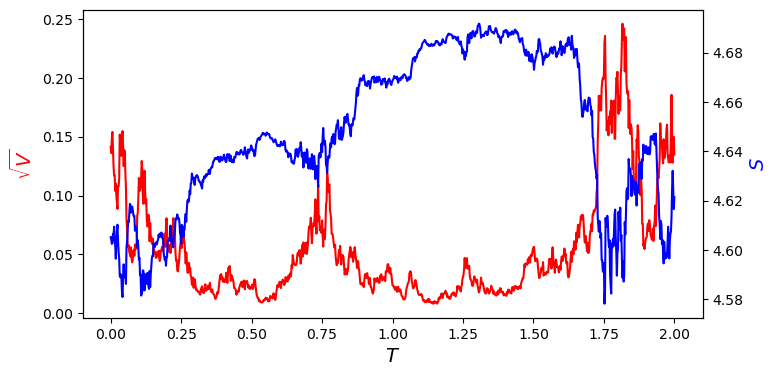

In [44]:
i_ind = 5
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax2 = ax.twinx()
lns2 = ax2.plot(tt,np.array(log_S[:,i_ind]), '-b',label = r'$S$')
lns1 = ax.plot(tt,np.sqrt(Vt[:,i_ind]), 'r',ls='-', label = r'$\sqrt{V}$')
labs = [l.get_label() for l in lns2+lns1]
ax.set_xlabel(r"$T$",size=14)
ax.set_ylabel(r'$\sqrt{V}$', color='red',size=14)
ax2.set_ylabel(r'$S$', color='blue',size=14)
plt.show()

For many stochastic volatility models there are no closed form formula for pricing the European vanilla call option of the form:

$$
C(t,K) = \mathbb{E} \left[(S_T-K)^+ \vert \mathcal F_t) \right].
$$

One can compute the expectation via Monte Carlo techniques with appropriate variance reduction techniques, for this is still too slow for pricing and model calibration.

See (McCrickerd and Pakkanen, 2018) for choice of control variates.



<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;"> Neural Network and deep pricing: supervised learning</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 


$\textbf{ref}$: (Horvath, Muguruza and Tomas, 2021)

Aim: approximate the pricing function: 

$$
f: X \rightarrow Y
$$

with a multi-layer Neural Network:

$$
f^{\mathcal{NN}}(\Theta) \approx f.
$$

$X$ denotes the parameter of the Bergomi model $\mathbb{R}^4 \ni X:= (\xi, \kappa,\eta,\rho)$, with $Y\in \mathbb{R_{+}}^{m\times d}$ the option prices (implied volatility) surface with a fixed vector of strikes $K\in{\mathbb{R}_{+}^{m}}$ and a fixed vector of maturities $T\in{\mathbb{R}_{+}^{d}}$.

$\Theta$ collectively denotes the weights and biases in a multi-layer neural network $f^{\mathcal{NN}}$.

For function $f$ is smooth enough, the $\textbf{Universal Approximation Theorem}$ provides uniform convergence as the number of weights goes to infinity


Here are steps you will follow to train our Neural Network:

1) Generate option pricing data via Monte Carlo simulations (computational intense)

2) Data preprocessing

3) Select Neural Network architecture and train

# Data preprocessing

We have a dataset of 40,000 observations consisting of the  4 params + a volatility surface with 88 implied volatilities ((11 prices (implied vol) for each 8 maturities slice by slice starting from shortest maturity)



In [57]:
import gzip

In [58]:
#xi,eta,kappa,rho
def print_params(x):
    print('xi = ' + str(x[0]),'\n','eta = ' + str(x[1]),'\n', 'kappa = ' + str(x[2]),'\n','rho = ' + str(x[3]),'\n')

In [59]:
raw_data = np.load(gzip.GzipFile('Bergomi1FactorTrainSet.txt.gz', "r"))
print(raw_data.shape)
X=raw_data[:,:4]
target_y=raw_data[:,4:]
print('X shape:', X.shape)
print('Y shape:', target_y.shape)
# 4 params + 88 option prices (11 prices for each 8 maturities slice by slice starting from shortest maturity:)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])*S0
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

(40000, 92)
X shape: (40000, 4)
Y shape: (40000, 88)


In [60]:
# print parameters
print_params(X[102])

xi = 0.0137982 
 eta = 2.4397 
 kappa = 2.01057 
 rho = -0.319205 



5. Split the Data between training (85%) and testing (15%) and normalise inputs between $[-1,1]$ and center/standardise outputs. 

In [61]:
#splitting the data to training and testing set
X_indexed = np.concatenate((np.arange(X.shape[0])[np.newaxis].T,X),axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
    X_indexed, target_y, test_size=0.15, random_state=42)

train_index = X_train[:,0].astype(int)
test_index = X_test[:,0].astype(int)
X_train = X_train[:,1:]
X_test = X_test[:,1:]

In [62]:
#Normalising input data x to the interval of [-1, 1]
def input_norm_transform(x, x_min, x_max, norm_min, norm_max):
    return (x-x_min)/(x_max-x_min)*(norm_max-norm_min)+norm_min
def input_norm_transform_inv(x_norm, x_min, x_max, norm_min, norm_max):
    return (x_norm-norm_min)/(norm_max-norm_min)*(x_max-x_min)+x_min

x_max = np.array([1.59997e-01,  3.99999e+00,  9.91655e+00, -7.11209e-06])
x_min = np.array([1.00178e-02,  5.00077e-01,  6.01685e-05, -9.99552e-01])
x_norm_min = -1
x_norm_max = 1

x_train_transform = input_norm_transform(X_train, x_min, x_max, x_norm_min, x_norm_max)
x_test_transform = input_norm_transform(X_test, x_min, x_max, x_norm_min, x_norm_max)

In [63]:
#Standardising output data y to the interval, so it is centred with variance 1
def output_norm_transform(y, mean, std):
    return (y-mean)/std
def output_norm_transform_inv(y_trans, mean, std):
    return y_trans*std+mean

y_mean = np.average(y_train,axis=0)
y_std = np.std(y_train,axis=0)

y_train_transform = output_norm_transform(y_train, y_mean, y_std)
y_test_transform = output_norm_transform(y_test, y_mean, y_std)

# Building the neural networks

6. Build a neural network using Sequential with 3 hidden layer with 30 neurons each using elu activation function for hidden layer. Then compile and train the model using adam optimizer and suitable loss function.

In [73]:
model_iv = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", input_shape=(4,)),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(y_train_transform.shape[1], activation="linear")
]    
)

model_iv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 30)                150       
                                                                 
 dense_8 (Dense)             (None, 30)                930       
                                                                 
 dense_9 (Dense)             (None, 30)                930       
                                                                 
 dense_10 (Dense)            (None, 88)                2728      
                                                                 
Total params: 4,738
Trainable params: 4,738
Non-trainable params: 0
_________________________________________________________________


In [74]:
#RMSE error function
def error_function(y_true, y_pred):
        return tf.sqrt(tf.math.reduce_mean((y_pred - y_true)**2))

In [75]:
model_iv.compile(optimizer="adam", loss=error_function)

In [76]:
train_hist=model_iv.fit(x_train_transform,  y_train_transform, batch_size=200, epochs=50)

Epoch 1/50
170/170 [==============================] - 1s 2ms/step - loss: 0.4435
Epoch 2/50
170/170 [==============================] - 0s 2ms/step - loss: 0.1679
Epoch 3/50
170/170 [==============================] - 0s 2ms/step - loss: 0.1231
Epoch 4/50
170/170 [==============================] - 0s 2ms/step - loss: 0.0949
Epoch 5/50
170/170 [==============================] - 0s 2ms/step - loss: 0.0734
Epoch 6/50
170/170 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 7/50
170/170 [==============================] - 0s 2ms/step - loss: 0.0494
Epoch 8/50
170/170 [==============================] - 0s 2ms/step - loss: 0.0440
Epoch 9/50
170/170 [==============================] - 0s 2ms/step - loss: 0.0402
Epoch 10/50
170/170 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 11/50
170/170 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 12/50
170/170 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 13/50
170/170 [====

In [56]:
model_iv.load_weights('1FBergomiNNWeights.h5')

In [29]:
NNParameters=[]
for i in range(0,len(model_iv.layers)):
    NNParameters.append(model_iv.layers[i].get_weights())

In [30]:
len(NNParameters[0][0])

4

### Transfer the learned NN to Numpy

This step is not mandatory but (!) To accelerate the calibration, we transfer the NN to numpy

In [78]:
NNParameters=[]
for i in range(0,len(model_iv.layers)):
    NNParameters.append(model_iv.layers[i].get_weights())

NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(4)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

## Validating Neural Network results

Validate the Neural Networks results

### Checking the training set

In [79]:
y_pred=output_norm_transform_inv(NeuralNetwork(x_train_transform), y_mean, y_std)

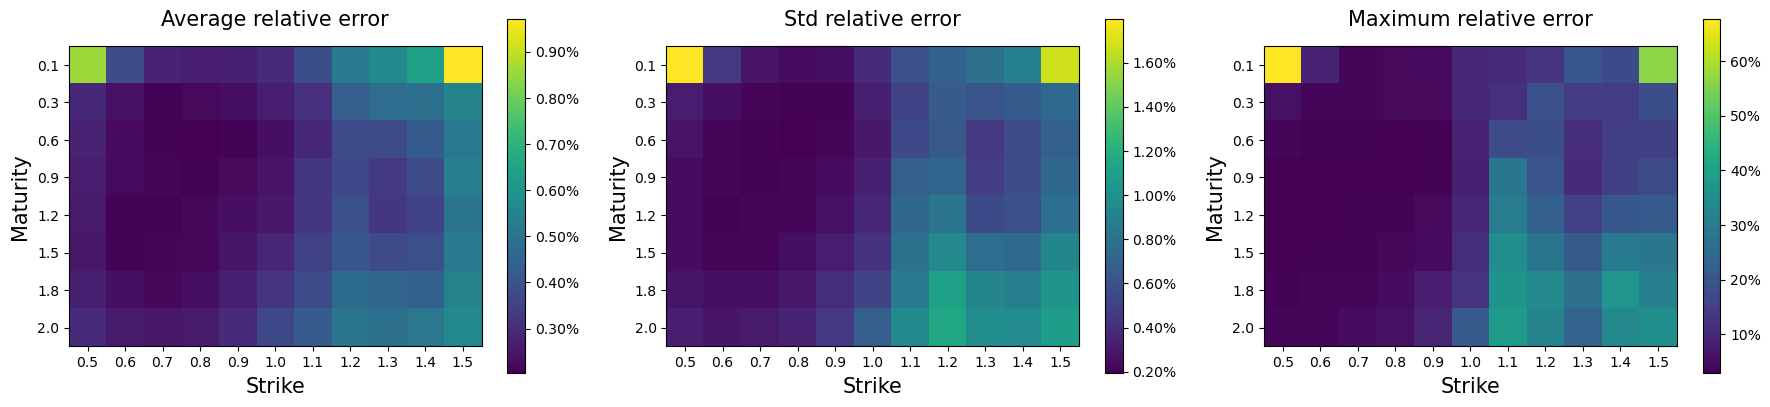

In [80]:
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######

plt.figure(1,figsize=(18,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((y_train-y_pred)/y_train),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((y_train-y_pred)/y_train),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((y_train-y_pred)/y_train),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.show()

### Checking the test set

In [81]:
y_pred=output_norm_transform_inv(NeuralNetwork(x_test_transform), y_mean, y_std)

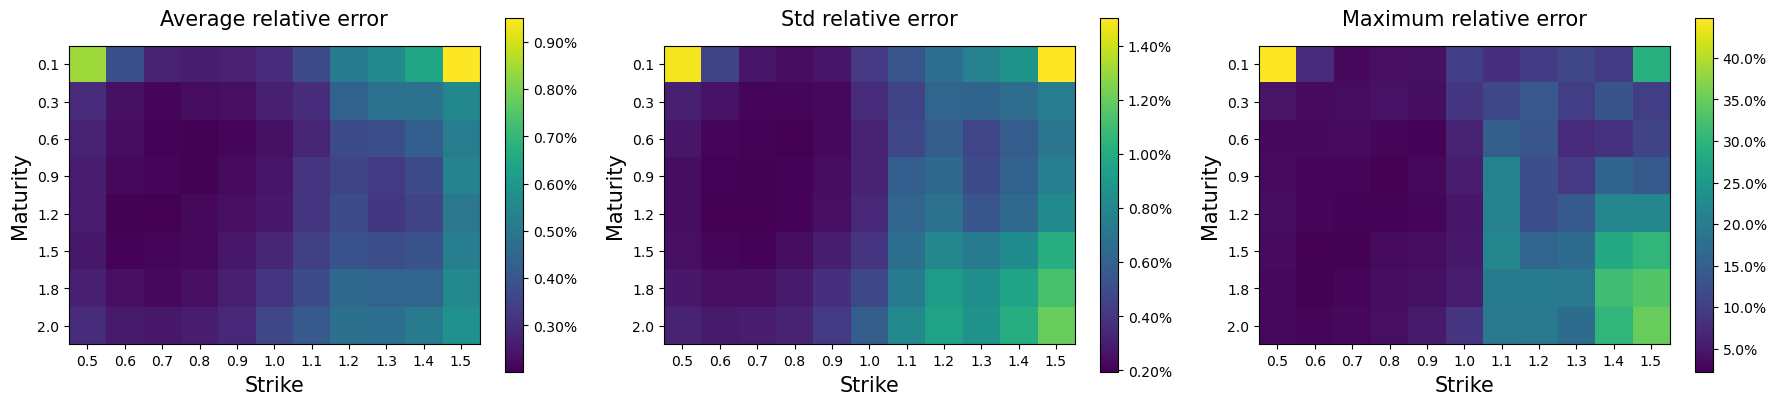

In [82]:
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######

plt.figure(1,figsize=(18,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((y_test-y_pred)/y_test),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((y_test-y_pred)/y_test),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((y_test-y_pred)/y_test),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.show()

xi = 0.156747 
 eta = 3.45116 
 kappa = 2.42921 
 rho = -0.0491344 



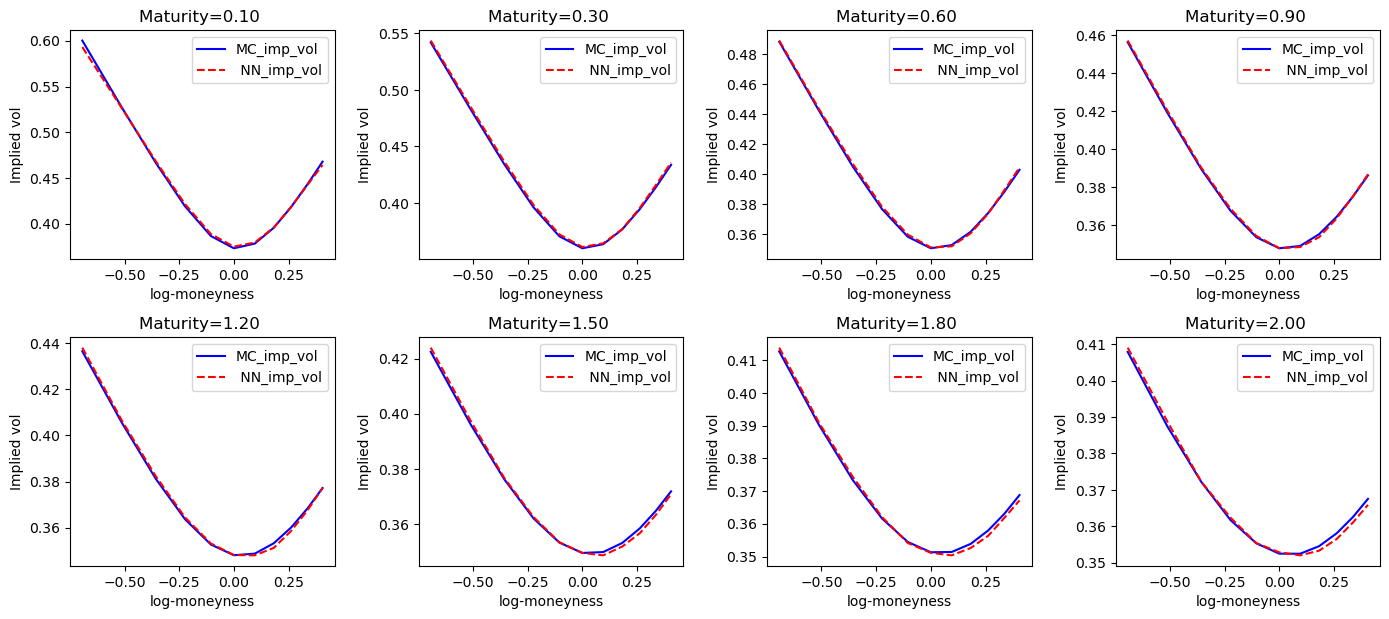

In [84]:
sample_ind = 100
X_input = X_test[sample_ind]
X_input_transform = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)
y_true = y_test[sample_ind]
print_params(X_input)

prediction=output_norm_transform_inv(NeuralNetwork(X_input_transform), y_mean, y_std)
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),y_true[i*strikes_dim:(i+1)*strikes_dim],'b',label="MC_imp_vol")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN_imp_vol")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

In [85]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
strikes_dim=11
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

def plot_func(xi0,eta,kappa,rho):
    x0 = input_norm_transform(np.array([xi0,eta,kappa,rho]), x_min, x_max, x_norm_min, x_norm_max)
    Smiles = output_norm_transform_inv(NeuralNetwork(x0).reshape(1,-1), y_mean, y_std)
    plt.figure(1,figsize=(14,12))
    for i in range(8):
        plt.subplot(4,4,i+1)

        
        plt.plot(np.log(strikes/S0),Smiles[0,i*strikes_dim:(i+1)*strikes_dim],'b',label=" NN Approx")

        #plt.ylim(0.1,0.8)
        plt.title("Maturity=%1.2f "%maturities[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show()
interact(plot_func, xi0 = widgets.FloatSlider(value=0.04,
                                               min=0.01,
                                               max=0.16,
                                               step=0.01),
        eta = widgets.FloatSlider(value=2.5,
                                               min=0.5,
                                               max=4.0,
                                               step=0.1),
        kappa = widgets.FloatSlider(value=1,
                                               min=0.5,
                                               max=9,
                                               step=0.1),
        rho = widgets.FloatSlider(value=-0.6,
                                               min=-0.95,
                                               max=-0.1,
                                               step=0.05))


interactive(children=(FloatSlider(value=0.04, description='xi0', max=0.16, min=0.01, step=0.01), FloatSlider(v…

<function __main__.plot_func(xi0, eta, kappa, rho)>

# Calibrate to SPX volatility surface 5/12/2017

In [86]:
spx_surface = np.array(pd.read_csv('spx_surface.csv',header=None)).reshape(-1)

In [89]:
#Cost Function for Levenberg Marquardt - not used
def CostFuncLS(x):
    spx_transform = output_norm_transform(spx_surface, y_mean, y_std)
    return (NeuralNetwork(x)-spx_transform)

init=np.zeros(X.shape[1])
opt_res = scipy.optimize.least_squares(CostFuncLS,init,gtol=1e-15)
print(opt_res)

 active_mask: array([0., 0., 0., 0.])
        cost: 0.10817610412935558
         fun: array([-5.45263865e-02, -6.85756298e-02, -1.28805666e-01, -1.40354299e-01,
       -7.21014406e-02,  2.96423018e-02,  1.09098385e-01,  2.41865555e-02,
        4.08141834e-02,  1.03267771e-01,  1.40722016e-01,  1.15008705e-01,
        6.82204781e-02,  2.98307233e-02, -6.44270331e-04, -3.23094678e-02,
       -5.99193542e-02, -5.14076200e-02, -6.58439348e-02, -6.91496042e-02,
       -2.72454965e-02,  1.51944878e-02,  4.03466068e-02,  1.78546245e-02,
       -3.21097823e-03, -9.58361173e-03, -3.67686507e-02, -5.38241118e-02,
       -5.76113719e-02, -5.90941328e-02, -7.63150433e-02, -8.53512391e-02,
       -8.17127629e-02,  1.36645021e-02, -1.04159032e-04,  3.73334388e-03,
       -4.93730784e-03, -1.38716074e-02, -1.52188594e-02, -2.09307027e-02,
       -2.77380183e-02, -3.50910354e-02, -5.21067732e-02, -7.81878624e-02,
       -2.19674052e-03, -1.55318965e-03, -5.34020696e-03,  3.93749113e-03,
       -2.3239

In [39]:
#Cost Function for Levenberg Marquardt - not used
def CostFuncLS(x):
    spx_transform = output_norm_transform(spx_surface, y_mean, y_std)
    return (NeuralNetwork(x)-spx_transform)
def JacobianLS(x):
    return NeuralNetworkGradient(x).T
init=np.zeros(X.shape[1])
opt_res = scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,gtol=1e-15)
print(opt_res)

 active_mask: array([0., 0., 0., 0.])
        cost: 0.10027803097161181
         fun: array([-5.58206114e-02, -6.70341031e-02, -1.09175603e-01, -1.40930317e-01,
       -6.28081815e-02,  2.39783909e-02,  1.07612703e-01,  4.32789025e-02,
        6.24042623e-02,  1.02532243e-01,  1.34336236e-01,  1.20196187e-01,
        7.23732939e-02,  3.21596309e-02,  2.61923318e-05, -2.75498431e-02,
       -5.78879986e-02, -4.87724081e-02, -5.55401929e-02, -4.94990656e-02,
       -1.66932471e-02,  1.43580436e-02,  3.24147777e-02,  8.75134478e-03,
       -2.12063789e-03, -1.31370330e-02, -2.50494145e-02, -4.24454644e-02,
       -6.14487075e-02, -5.17590648e-02, -6.26538500e-02, -7.46291727e-02,
       -8.07476046e-02,  1.12422529e-02, -2.00895293e-03,  9.25078102e-03,
        6.13455984e-03,  2.90322783e-03, -1.53984225e-02, -2.96330088e-02,
       -2.67682333e-02, -2.80065569e-02, -4.79645294e-02, -8.22541360e-02,
       -9.51280234e-03, -1.00869607e-02,  6.93412334e-03,  1.53044808e-02,
        5.8706

In [90]:
calib_params = input_norm_transform_inv(opt_res.x, x_min, x_max, x_norm_min, x_norm_max)
print_params(calib_params)

xi = 0.04419983538065376 
 eta = 3.6944549730909815 
 kappa = 4.286025285068351 
 rho = -0.7704073241196066 



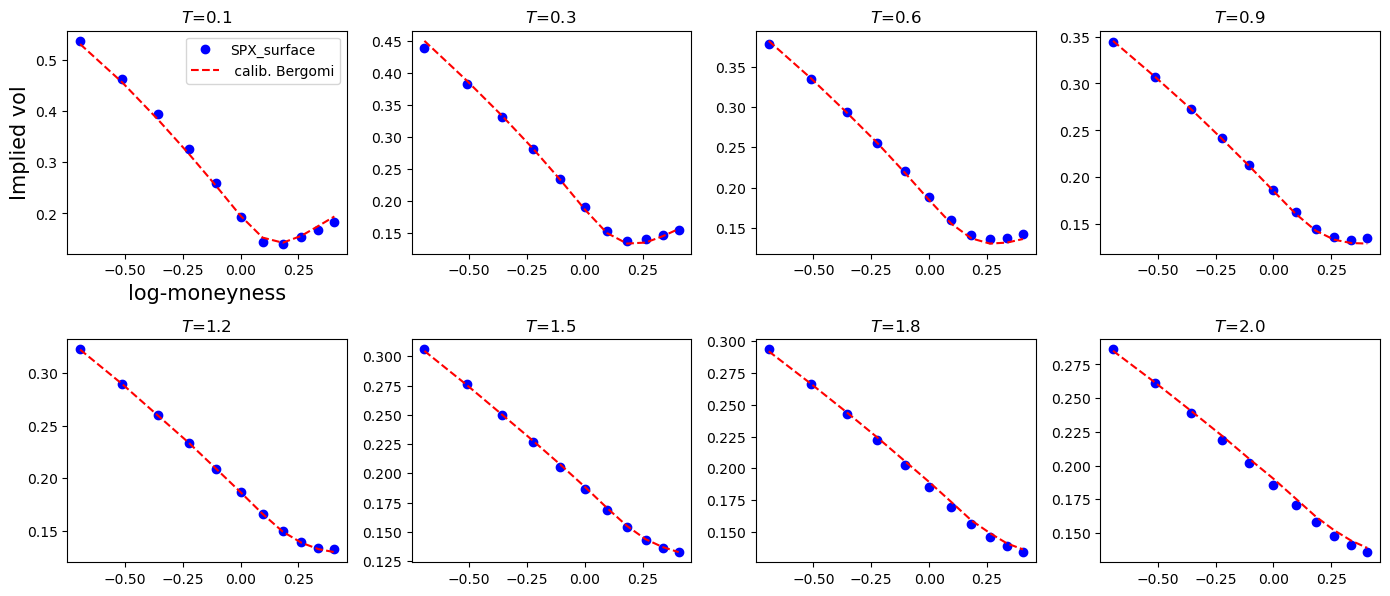

In [91]:
calib_surface=output_norm_transform_inv(NeuralNetwork(opt_res.x), y_mean, y_std)
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),spx_surface[i*strikes_dim:(i+1)*strikes_dim],color='b',marker='o', linestyle='',label="SPX_surface")
    plt.plot(np.log(strikes/S0),calib_surface[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" calib. Bergomi")
    plt.title(r"$T$=%1.1f "%maturities[i])

    if i ==0:
        plt.legend()
        plt.xlabel("log-moneyness",size=15)
        plt.ylabel("Implied vol",size=15)
plt.tight_layout()
plt.show()

# References

1)  Bruno Dupire. Arbitrage pricing with stochastic volatility. Société Générale, 1992

2)  Lorenzo Bergomi. Smile dynamics II. Risk Magazine, 2005

3) Ryan McCrickerd and Mikko S Pakkanen. Turbocharging monte carlo pricing for the rough 
bergomi model. Quantitative Finance, 18(11):1877–1886, 201

4) Blanka Horvath, Aitor Muguruza, and Mehdi Tomas. Deep learning volatility: a deep neural 
network perspective on pricing and calibration in (rough) volatility models. Quantitativ 
Finance, 21(1):11–27, 20218